# Otimização dos hiperparâmetros

Notebook que realiza a otimização e salva os melhores hiperparâmetros dos 3 modelos.

In [1]:
import sys
sys.path.append('..')
import pickle
import optuna
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_param_importances, plot_slice
import matplotlib.pyplot as plt
import torch
from src.data.data import LoFiDataset
from src.optimization.optuna_vae import objective

c:\Users\Suporte\Anaconda3\envs\AMAP_Proj\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
path_to_save = r"../data/processed/best_hyperparams.pkl"
n_trials = 5
#models = ["dense", "conv", "lstm"]
models = ["lstm"]
n_epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


Total de arquivos: 2611


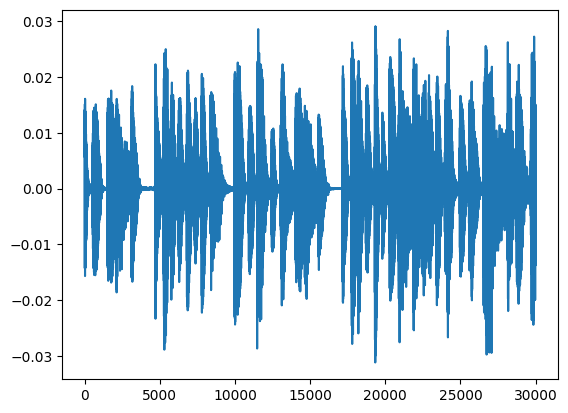

In [ ]:
dataset = LoFiDataset('../data/raw')
print(f"Total de arquivos: {len(dataset)}")
plt.plot(dataset[30])
plt.show()

## Inicialização do optuna

In [4]:
studies = {model:None for model in models}
for model_name in studies.keys():
    print(f"Otimização do modelo {model_name} iniciada!")
    studies[model_name] = optuna.create_study(direction="minimize")
    studies[model_name].optimize(lambda trial: objective(trial, model_name, n_epochs, dataset, device), n_trials=n_trials)
    pruned_trials = [t for t in studies[model_name].trials if t.state == optuna.trial.TrialState.PRUNED]
    complete_trials = [t for t in studies[model_name].trials if t.state == optuna.trial.TrialState.COMPLETE]
    print(f"Número de trials finalizadas: {len(studies[model_name].trials)}")
    print(f"Número de trials podadas: {len(pruned_trials)}")
    print(f"Número de trials completas: {len(complete_trials)}")
    print(f"Otimização do modelo {model_name} finalizada!")

Otimização do modelo lstm iniciada!

[I 2025-02-21 00:05:18,868] A new study created in memory with name: no-name-5083751f-96a0-42fd-99d2-8520f19365a1


[I 2025-02-21 00:05:49,843] Trial 0 finished with value: 0.002728712964145576 and parameters: {'num_layers': 1, 'latent_dim': 2, 'output_neurons': 50, 'middle_ground': 150}. Best is trial 0 with value: 0.002728712964145576.


	[TRAINING] Epoch 1 	Average train Loss:  0.00660446101348057 	Average test Loss:  0.002728712964145576


[I 2025-02-21 00:06:22,814] Trial 1 finished with value: 0.0010901501381714992 and parameters: {'num_layers': 3, 'latent_dim': 5, 'output_neurons': 200, 'middle_ground': 150}. Best is trial 1 with value: 0.0010901501381714992.


	[TRAINING] Epoch 1 	Average train Loss:  0.0030580963286796978 	Average test Loss:  0.0010901501381714992


[I 2025-02-21 00:06:49,803] Trial 2 finished with value: 0.001586515860467711 and parameters: {'num_layers': 2, 'latent_dim': 5, 'output_neurons': 100, 'middle_ground': 150}. Best is trial 1 with value: 0.0010901501381714992.


	[TRAINING] Epoch 1 	Average train Loss:  0.0047440789075511875 	Average test Loss:  0.001586515860467711


[I 2025-02-21 00:07:24,698] Trial 3 finished with value: 0.0007168464003103401 and parameters: {'num_layers': 3, 'latent_dim': 2, 'output_neurons': 200, 'middle_ground': 75}. Best is trial 3 with value: 0.0007168464003103401.


	[TRAINING] Epoch 1 	Average train Loss:  0.0012731152863566283 	Average test Loss:  0.0007168464003103401


[I 2025-02-21 00:07:53,193] Trial 4 finished with value: 0.0018586213905912113 and parameters: {'num_layers': 1, 'latent_dim': 2, 'output_neurons': 50, 'middle_ground': 75}. Best is trial 3 with value: 0.0007168464003103401.


	[TRAINING] Epoch 1 	Average train Loss:  0.0035492724555572777 	Average test Loss:  0.0018586213905912113
Número de trials finalizadas: 5
Número de trials podadas: 0
Número de trials completas: 5
Otimização do modelo lstm finalizada!


## Melhores hiperparâmetros

### LSTM

In [ ]:
studies["lstm"].best_params

{'num_layers': 3, 'latent_dim': 2, 'output_neurons': 200, 'middle_ground': 75}

In [ ]:
#pip install -U Kaleido=0.1.0.post1
fig = plot_optimization_history(studies["lstm"])
fig.write_image("../reports/figures/lstm_optmization_history.pdf")
fig

In [14]:
fig = plot_parallel_coordinate(studies["lstm"])
fig.write_image("../reports/figures/lstm_optmization_parallel_coordinate.pdf")
fig

In [15]:
fig = plot_param_importances(studies["lstm"])
fig.write_image("../reports/figures/lstm_optmization_importances.pdf")
fig

### Salvando os dicts dos hiperparâmetros

In [9]:
best_params = {model:studies[model].best_params for model in models}

In [10]:
with open(path_to_save, "wb") as f:
    pickle.dump(best_params, f)